In [1]:
# Importing libraries and modules
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("SDEutils.jl")
using .SDEutils, Plots, Statistics, Distributions, KernelDensity, StatsBase, LinearAlgebra, LaTeXStrings

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Biochemical Reaction Kinetics

$$ 
\begin{align}
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{more Biomass X}, \\
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{Product Y}.
\end{align}
$$

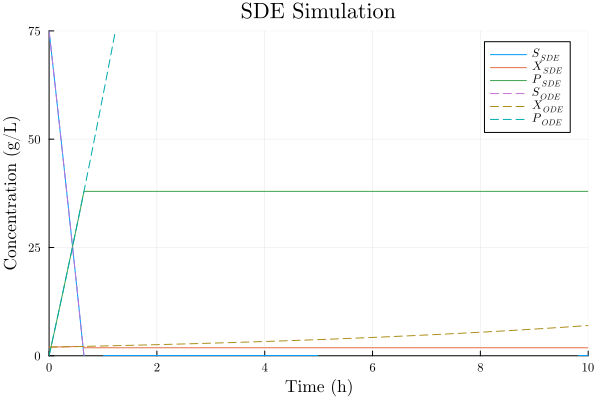

In [5]:
# Setting up the model parameters
# The parameters are defined in a dictionary for easy access and modification
params  = Dict(
    "μ_max" => 0.125, # Maschmeier
    "K_sx" => 0.147, # Maschmeier
    "Y_xs" => 0.531, # Maschmeier
    "Y_ys" => 0.508, # Maschmeier
    "m_s" => 0.005, # Fogler
    "q_max_y" => 28.188, # Maschmeier
    "K_sy" => 0.0175, # Maschmeier
    "σs" => 1.0, # Arbitrary
    "σx" => 1.0, # Arbitrary
    "σy" => 1.0 # Arbitrary
)

# params  = Dict(
#     "μ_max" => 0.244, # Zentou et al 
#     "K_sx" => 11.55, # Zentou et al
#     "Y_xs" => 0.28, # Zentou et al
#     "Y_ys" => 0.42, # Zentou et al
#     "m_s" => 0.015, # Villadsen
#     "q_max_y" => 1.79, # Nagy
#     "K_sy" => 1.68, # Nagy
#     "σs" => 3.0, # Arbitrary
#     "σx" => 3.0, # Arbitrary
#     "σy" => 3.0 # Arbitrary
# )

# Initial conditions for the state variables
# The initial conditions are defined in a dictionary for easy access and modification
init = Dict(
    "S0" => 75.0, 
    "X0" => 2.0, 
    "Y0" => 0
)

# Time parameters
T = 10.0  # Time span for the simulation
dt = 0.001  # Time step for the simulation
N = Int(T / dt)  # Number of time steps
tsteps = 0:dt:T  # Time steps array

# Running the Monte Carlo simulation
M = 1_000  # Number of Monte Carlo simulations
sdesol = simulate_paths(params, T, init, M, dt)[1]
odesol = simulate_paths(params, T, init, M, dt)[2]

# Storing the results in matrices for each state variable
S = zeros(length(sdesol), length(sdesol[1].t))
X = zeros(length(sdesol), length(sdesol[1].t))
Y = zeros(length(sdesol), length(sdesol[1].t))

for i in 1:length(sdesol)
    S[i, :] = sdesol[i][1, :]
    X[i, :] = sdesol[i][2, :]
    Y[i, :] = sdesol[i][3, :]
end

# Plotting the results
plot(sdesol[353], title="SDE Simulation", label=[L"S_{SDE}" L"X_{SDE}" L"P_{SDE}"], xlabel="Time (h)", ylabel="Concentration (g/L)")
plot!(odesol, title="SDE Simulation", label=[L"S_{ODE}" L"X_{ODE}" L"P_{ODE}"], xlabel="Time (h)", ylabel="Concentration (g/L)", linestyle=:dash)
plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["S0"]), xlims=(0, T))

### Longstaff-Schwartz Algorithm

In [6]:
# Stopping index
τ = fill(length(tsteps), M)

# Longstaff-Schwartz setup
V = copy(S)  # reward values
degree = 3
β_matrix = zeros(length(tsteps), degree + 1)

# Threshold for substrate depletion
S0 = init["S0"]  # initial substrate
thresh = 0.05 * S0

# Backward induction
for n in (length(tsteps)-1):-1:2
    s_now = S[:, n]
    future = V[:, n+1]

    # In-the-money = substrate depleted enough
    itm_indices = findall(s -> s ≤ thresh, s_now)
    if length(itm_indices) < 10
        continue
    end

    s_itm = [Ss[i,n] for i in itm_indices]  
    vf_itm = future[itm_indices]

    # Regression
    Φ = laguerre_design_matrix(s_itm, degree)
    β = Φ \ vf_itm
    continuation_value = Φ * β

    # Reward for stopping: earlier = better
    immediate_reward = fill(-tsteps[n], length(itm_indices))

    # Compare and decide to stop or not
    for (j, i) in enumerate(itm_indices)
        if immediate_reward[j] ≥ continuation_value[j]
            V[i, n] = immediate_reward[j]
            τ[i] = min(τ[i], n)
        else
            V[i, n] = V[i, n+1]
        end
    end

    β_matrix[n, :] .= β
end

# Final outputs
τ_times = [tsteps[τ[i]] for i in 1:M]

histogram(τ_times, bins=30, xlabel="Stopping Time (S depleted)", ylabel="Frequency", title="Optimal Stopping Time Histogram")


UndefVarError: UndefVarError: `Ss` not defined in `Main`
Suggestion: check for spelling errors or missing imports.